# 프로젝트 - Movielens 영화 SBR
Movielens 1M Dataset을 기반 Session based Recommendation 시스템을 제작

In [373]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [374]:
#!pip install -r requirements.txt

In [375]:
from google.colab import drive
drive.mount('/content/drive')

data_path = Path('/content/drive/My Drive/Aiffel Project/Recommendation_System/data/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [376]:
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Unix_Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Unix_Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

data

,UserId,ItemId,Rating,Unix_Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [377]:
# Unix_Time 을 연월일 시분초 형식으로 변환
data['Time'] = pd.to_datetime(data['Unix_Time'], unit='s')
data

,UserId,ItemId,Rating,Unix_Time,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 Unix Time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

유저(UserId)수와 영화(ItemId)수 확인

In [378]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## *문제해결 전략*

세션과는 다르게 UserId의 각 unique값의 개수는 유저수를 의미한다.

따라서 Movielens Dataset 에 Session-based recommendation 을 적용하기 위해

1. UserId를 기준으로 데이터를 그룹화한 뒤, 1개월을 기준으로 Session을 나눈다.

2. 나눈 Session에 임의의 Session_id를 부여한다.

3. 선호 영화를 추천한다는 맥락에 맞추기 위해 Rating이 3 이하인 데이터는 제거한다.

1개월을 기준으로 Session을 나눈 이유는 일반적으로 영화 평점을 메기는 일은 쇼핑하기 위해 홈페이지를 클릭하는 것과 다르다고 생각하기 때문이다. 베이스라인 모델로 영화 관람 주기를 1개월 단위로 생각하여 Session을 정의한다.

In [379]:
# Rating 값이 4 이상인 데이터만 추출
data = data[data['Rating'] >= 4]
data

,UserId,ItemId,Rating,Unix_Time,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
36,1,1836,5,978300172,2000-12-31 22:02:52
...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04


In [380]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 575281 entries, 31 to 1000042
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UserId     575281 non-null  int32         
 1   ItemId     575281 non-null  int32         
 2   Rating     575281 non-null  int32         
 3   Unix_Time  575281 non-null  int64         
 4   Time       575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 19.8 MB


In [381]:
#data.groupby('UserId')['Time'].min()

In [382]:
#data.groupby('UserId')['Time'].min()[3]

In [383]:
# Movielens 데이터를 UserId 기준으로 그룹화하고, 데이터 생성 시간 30분 단위로 독립적인 세션을 생성 - 약 1분 30초 소요
sessions = []
session_id = 0
for Id, group in data.groupby('UserId'):
    initial_time = data.groupby('UserId')['Unix_Time'].min()[Id]
    session_id += 1
    for _, row in group.iterrows():
        if (row['Unix_Time'] - initial_time) > 90 * 60:
            session_id += 1
            initial_time = row['Unix_Time']
        sessions.append(session_id)

## Ruburic 1.
: Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.

## ㄴ 문제해결 회고 1
1. 주어진 Movielens 데이터를 UserId를 기준으로 그룹화
2. 각 그룹을 불러올 때마다 그 그룹의 첫번째 시간(오름차순 정렬이므로)을 initial_time에 저장
3. 새로운 그룹의 iteration이 시작되면 session_id 값을 +1 하여 이전 그룹의 session_id와 구분
4. 조건문으로 해당 UserId 그룹의 각 레코드의 시간차가 30분을 초과하면 session_id 값을 +1 하고 해당 레코드의 시간을 initial_time으로 최신화.
5. 위 과정을 거친 각 레코드에 해당하는 session_id를 리스트 sessions에 할당

## ㄴ 문제해결 회고 2
1. 연월일 시분초 시간으로 계산을 하면 아래 그림에 해당하는 데이터의 세션 분류가 제대로 이루어지지 않았다.

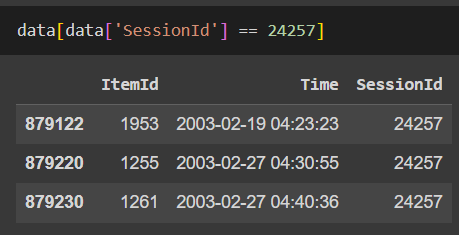

2. 따라서 Unix 시간을 기준으로 세션을 생성하는 코드를 수정하여 문제를 해결하였다.

In [384]:
# SessionId 개수 확인 - Unix_Time을 기준으로 했을 때와 연월일시분초 Time을 기준으로 했을 때 세션 생성에 차이를 발견하였다.
len(set(sessions))

21803

## ㄴ 문제해결 회고 3
: 세션 정의를 90분으로 했을 때 가장 높은 예측성능이 나타났다. 따라서 세션을 90분 단위로 정하여 진행한다.

In [385]:
data['SessionId'] = sessions
data

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
...,...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27,21802
999923,6040,232,5,997454398,2001-08-10 14:39:58,21802
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,21802
999988,6040,1921,4,997454464,2001-08-10 14:41:04,21802


In [386]:
# 90분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 1]

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
3,1,3408,4,978300275,2000-12-31 22:04:35,1
7,1,2804,5,978300719,2000-12-31 22:11:59,1
47,1,1207,4,978300719,2000-12-31 22:11:59,1
0,1,1193,5,978300760,2000-12-31 22:12:40,1
44,1,260,4,978300760,2000-12-31 22:12:40,1


In [387]:
# 90분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 2]

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
130,2,1198,4,978298124,2000-12-31 21:28:44,3
64,2,1210,4,978298151,2000-12-31 21:29:11,3
88,2,1293,5,978298261,2000-12-31 21:31:01,3
170,2,2943,4,978298372,2000-12-31 21:32:52,3
106,2,1225,5,978298391,2000-12-31 21:33:11,3
...,...,...,...,...,...,...
58,2,648,4,978299913,2000-12-31 21:58:33,3
84,2,368,4,978300002,2000-12-31 22:00:02,3
129,2,736,4,978300100,2000-12-31 22:01:40,3
167,2,2002,5,978300100,2000-12-31 22:01:40,3


In [388]:
# 90분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 3]

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
202,3,2858,4,978297039,2000-12-31 21:10:39,4
230,3,1968,4,978297068,2000-12-31 21:11:08,4
225,3,1961,4,978297095,2000-12-31 21:11:35,4
209,3,1266,5,978297396,2000-12-31 21:16:36,4
216,3,1378,5,978297419,2000-12-31 21:16:59,4
218,3,1379,4,978297419,2000-12-31 21:16:59,4
226,3,3671,5,978297419,2000-12-31 21:16:59,4
212,3,590,4,978297439,2000-12-31 21:17:19,4
201,3,260,5,978297512,2000-12-31 21:18:32,4
211,3,1196,4,978297539,2000-12-31 21:18:59,4


In [389]:
# 90분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 4]

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
244,4,1097,4,978293964,2000-12-31 20:19:24,5
233,4,3468,5,978294008,2000-12-31 20:20:08,5
240,4,480,4,978294008,2000-12-31 20:20:08,5
238,4,260,5,978294199,2000-12-31 20:23:19,5
242,4,1198,5,978294199,2000-12-31 20:23:19,5
248,4,1387,5,978294199,2000-12-31 20:23:19,5
239,4,2028,5,978294230,2000-12-31 20:23:50,5
247,4,2366,4,978294230,2000-12-31 20:23:50,5
250,4,1201,5,978294230,2000-12-31 20:23:50,5
251,4,2692,5,978294230,2000-12-31 20:23:50,5


In [390]:
# 세션 분류 문제가 있을 때 직접 확인하는 코드

# pd.set_option('display.max_rows', 300)

# # Time 컬럼과 SessionId 컬럼을 기준으로 오름차순으로 정렬
# sorted_df = data.sort_values(by=['Time', 'SessionId'], ascending=True)

# # 뒷부분 200개의 레코드 출력
# last_200_records = sorted_df.tail(300)

# print(last_200_records)

# pd.reset_option('display.max_rows')

In [391]:
pd.Series(sessions).nunique()

21803

#### ㄴ 6040명 유저로부터 총 21,803개의 90분 단위 세션이 생성된 것으로 확인

세션 수와 아이템 수 확인

In [392]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(21803, 3533)

각 세션이 몇 개의 rating 데이터로 이루어져 있는지 탐색

In [393]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        34
2        11
3        73
4        37
5        18
         ..
21799     5
21800    10
21801     1
21802    17
21803     1
Length: 21803, dtype: int64

여기서 session_length는 같은 SessionId를 공유하는 데이터 row의 개수를 의미한다.

In [394]:
session_length.median(), session_length.mean()

(7.0, 26.38540567811769)

In [395]:
session_length.min(), session_length.max()

(1, 584)

In [396]:
session_length.quantile(0.99)

208.0

In [397]:
session_length.describe()

count    21803.000000
mean        26.385406
std         42.929812
min          1.000000
25%          1.000000
50%          7.000000
75%         33.000000
max        584.000000
dtype: float64

같은 시간에 동시적으로 5개 이상의 rating을 한 데이터 또한 탐색과정에서 발견하였다. 이러한 Movielens Dataset에 대하여 조사한 결과 아래와 같은 내용을 확인하였다.

질문 : 시간이 초 단위로 구성되있는데 값은 시간에 여러개의 rating을 한 경우는 무엇인가?..

Movielens 1M Dataset은 Unix 시간대를 기준으로 구성되어 있습니다. 한 유저가 동일한 시간에 여러 영화에 대해 rating을 한 경우, 이는 일반적으로 오류라기보다는 해당 사용자가 한 번에 여러 영화에 대해 rating을 남겼다는 것을 의미합니다.

이러한 경우는 다양한 상황에서 발생할 수 있습니다:

Batch Rating: 사용자가 여러 영화에 대한 평가를 묶어서 한 번에 입력한 경우. 이는 특정 이벤트나 관련된 영화를 묶어서 한꺼번에 평가할 수 있는 상황에서 발생할 수 있습니다.

Automation: 사용자가 자동화된 프로그램이나 서비스를 통해 여러 영화에 대한 평가를 한 경우. 이는 추천 시스템이나 기타 서비스를 구현할 때 자동으로 평가를 입력하는 경우입니다.

In [398]:
long_session = session_length[session_length==584].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
307124,1835,1270,5,974877069,2000-11-22 07:11:09,7338
307335,1835,3471,5,974877069,2000-11-22 07:11:09,7338
307425,1835,1175,4,974877069,2000-11-22 07:11:09,7338
307449,1835,1196,5,974877069,2000-11-22 07:11:09,7338
307797,1835,1214,5,974877069,2000-11-22 07:11:09,7338
...,...,...,...,...,...,...
307147,1835,1298,5,974882434,2000-11-22 08:40:34,7338
307708,1835,1035,5,974882434,2000-11-22 08:40:34,7338
307830,1835,2971,5,974882434,2000-11-22 08:40:34,7338
307447,1835,661,4,974882448,2000-11-22 08:40:48,7338


In [399]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.263175
2      0.352658
3      0.402743
4      0.437463
5      0.461542
         ...   
314    0.998808
315    0.998853
319    0.998899
321    0.998945
325    0.998991
Length: 287, dtype: float64

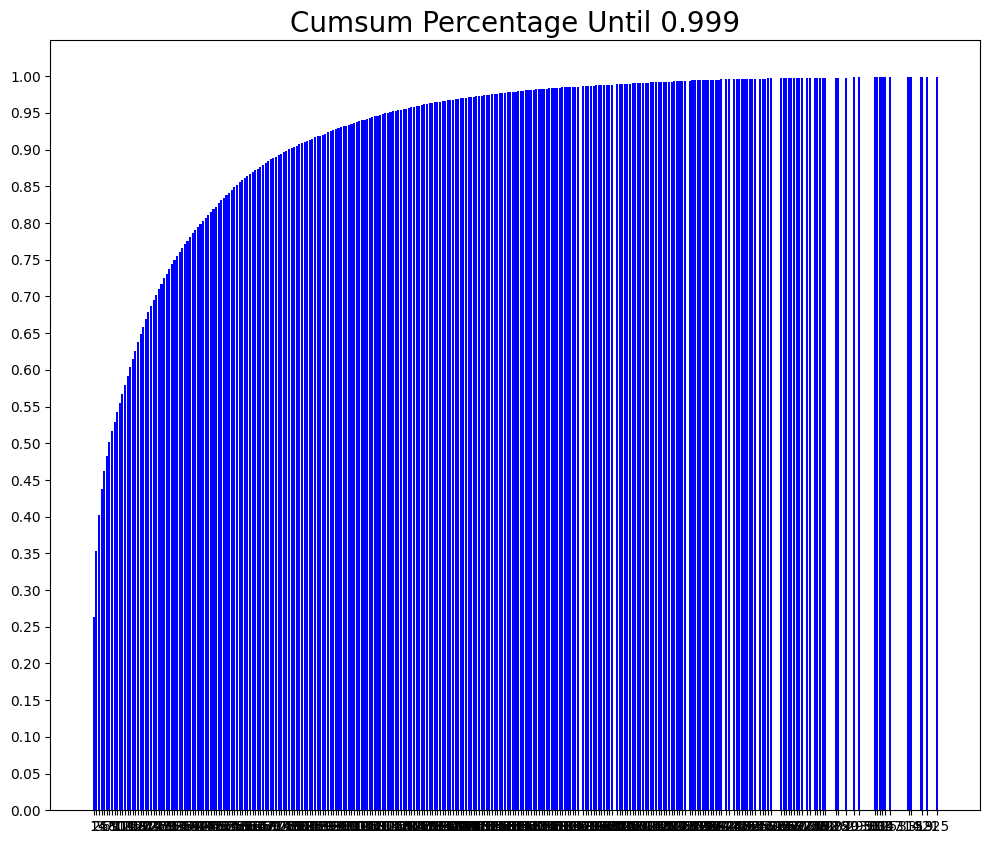

In [400]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [401]:
# 필터링 코드

# filtered_sessions = session_length[session_length<118.0].index.tolist()
# len(filtered_sessions)
# data = data[data['SessionId'].isin(filtered_sessions)]

In [402]:
# 불필요한 컬럼 삭제 코드

#data.drop(['UserId', 'Rating'], axis=1, inplace=True)

In [403]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 575281 entries, 31 to 1000042
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UserId     575281 non-null  int32         
 1   ItemId     575281 non-null  int32         
 2   Rating     575281 non-null  int32         
 3   Unix_Time  575281 non-null  int64         
 4   Time       575281 non-null  datetime64[ns]
 5   SessionId  575281 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(2)
memory usage: 24.1 MB


### 시간(Time)에 따른 분석

Movielens 데이터의 시간 관련 정보를 확인

In [404]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년치 데이터를 확인

In [405]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.

날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용한다.

약 3년치 데이터 중 최근 60일 데이터를 활용해 모델링을 수행했을 때 가장 높은 예측성능을 확인하였다.

In [406]:
month_ago = latest - dt.timedelta(60)     # 최종 날짜로부터 60일 이전 날짜를 구한다.
data_truncated = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다.
#data_truncated = data

### Data Cleansing
Movielens 데이터에서 SBR 태스크를 수행하기 위해 rating이 최소 2개 이상 포함된 SessionId만 남겨놓는다.

In [407]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [408]:
data_truncated = cleanse_recursive(data_truncated, shortest=2, least_click=5)
data_truncated

,UserId,ItemId,Rating,Unix_Time,Time,SessionId
8798,59,2396,4,1041962835,2003-01-07 18:07:15,130
8733,59,2300,4,1041966942,2003-01-07 19:15:42,130
8879,59,1220,4,1041967022,2003-01-07 19:17:02,130
8728,59,750,4,1041967123,2003-01-07 19:18:43,130
8876,59,541,4,1041967123,2003-01-07 19:18:43,130
...,...,...,...,...,...,...
974480,5878,1220,4,1043784424,2003-01-28 20:07:04,21312
984590,5950,1196,4,1046368417,2003-02-27 17:53:37,21552
984713,5950,3911,4,1046369026,2003-02-27 18:03:46,21552
984731,5950,3948,4,1046369637,2003-02-27 18:13:57,21552


## 2.5 Train / Valid / Test split
모델 평가를 위한 Valid Set과 Test Set 생성

사용자들의 소비 패턴은 시간의 흐름에 따라 달라진다.

따라서 가장 마지막 5일 기간 동안을 Test로, 6 ~ 10일 전 까지를 valid set으로 나눈다.

실험 결과 2달 전 데이터로 모델링했을 때 예측성능이 가장 높게 나왔다.

In [409]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [410]:
tr, test = split_by_date(data_truncated, n_days=5)
tr, val = split_by_date(tr, n_days=5)

In [411]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [412]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 112
	 Sessions: 30
	 Items: 22
	 First Time : 2002-12-30 19:40:24
	 Last Time : 2003-02-17 00:14:20

* valid Set Stats Info
	 Events: 12
	 Sessions: 3
	 Items: 12
	 First Time : 2003-02-20 03:04:56
	 Last Time : 2003-02-22 06:36:58

* test Set Stats Info
	 Events: 9
	 Sessions: 3
	 Items: 8
	 First Time : 2003-02-23 17:44:04
	 Last Time : 2003-02-27 18:14:30



In [413]:
tr['Time'].sort_values()

76403    2002-12-30 19:40:24
76287    2002-12-30 19:40:25
76436    2002-12-30 19:40:25
719049   2003-01-01 13:49:07
718736   2003-01-01 13:55:59
                 ...        
62126    2003-02-10 18:22:08
906672   2003-02-17 00:04:43
906600   2003-02-17 00:04:43
906646   2003-02-17 00:05:11
906623   2003-02-17 00:14:20
Name: Time, Length: 112, dtype: datetime64[ns]

In [414]:
val['Time'].sort_values()

113619   2003-02-20 03:04:56
113575   2003-02-20 03:08:40
113588   2003-02-20 03:09:25
113540   2003-02-20 03:10:14
113642   2003-02-20 03:11:48
113621   2003-02-20 03:17:37
113640   2003-02-20 03:26:13
113628   2003-02-20 03:36:35
906636   2003-02-20 17:58:16
906658   2003-02-20 17:58:16
882394   2003-02-22 06:24:12
882004   2003-02-22 06:36:58
Name: Time, dtype: datetime64[ns]

In [415]:
test['Time'].sort_values()

739500   2003-02-23 17:44:04
739504   2003-02-23 17:50:16
637543   2003-02-24 17:03:18
637572   2003-02-24 18:14:27
637561   2003-02-24 18:20:55
984590   2003-02-27 17:53:37
984713   2003-02-27 18:03:46
984731   2003-02-27 18:13:57
984682   2003-02-27 18:14:30
Name: Time, dtype: datetime64[ns]

In [416]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [417]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 112
	 Sessions: 30
	 Items: 22
	 First Time : 2002-12-30 19:40:24
	 Last Time : 2003-02-17 00:14:20

* valid Set Stats Info
	 Events: 12
	 Sessions: 3
	 Items: 12
	 First Time : 2003-02-20 03:04:56
	 Last Time : 2003-02-22 06:36:58

* test Set Stats Info
	 Events: 9
	 Sessions: 3
	 Items: 8
	 First Time : 2003-02-23 17:44:04
	 Last Time : 2003-02-27 18:14:30



In [418]:
save_path = data_path / 'processed_movielens'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Data Pipeline
Session-Parallel Mini-Batch 구현

### 4.1 SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [419]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId #### 문제살펴보기

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.

session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [420]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Unix_Time,Time,SessionId,item_idx
8798,59,2396,4,1041962835,2003-01-07 18:07:15,130,0
8733,59,2300,4,1041966942,2003-01-07 19:15:42,130,1
8879,59,1220,4,1041967022,2003-01-07 19:17:02,130,2
8728,59,750,4,1041967123,2003-01-07 19:18:43,130,3
8876,59,541,4,1041967123,2003-01-07 19:18:43,130,4
...,...,...,...,...,...,...,...
974443,5878,32,5,1043781375,2003-01-28 19:16:15,21312,17
974677,5878,2395,4,1043781938,2003-01-28 19:25:38,21312,10
974219,5878,3081,5,1043782823,2003-01-28 19:40:23,21312,11
974750,5878,541,5,1043784115,2003-01-28 20:01:55,21312,4


In [421]:
tr_dataset.click_offsets

array([  0,   6,   8,  25,  32,  35,  38,  40,  43,  47,  49,  51,  55,
        57,  59,  63,  65,  70,  72,  74,  77,  79,  82,  88,  91,  93,
        97,  99, 101, 104, 112], dtype=int32)

In [422]:
len(tr_dataset.click_offsets)

31

In [423]:
tr_dataset.session_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [424]:
len(tr_dataset.session_idx)

30

## 4.2 SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [425]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            #end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]
            end[idx] = self.dataset.click_offsets[min(self.dataset.session_idx[new_session] + 1, len(self.dataset.click_offsets) - 1)]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

## ㄴ 문제해결 회고 4
1. train 단계에서 아래와 같은 문제가 발생하였다.

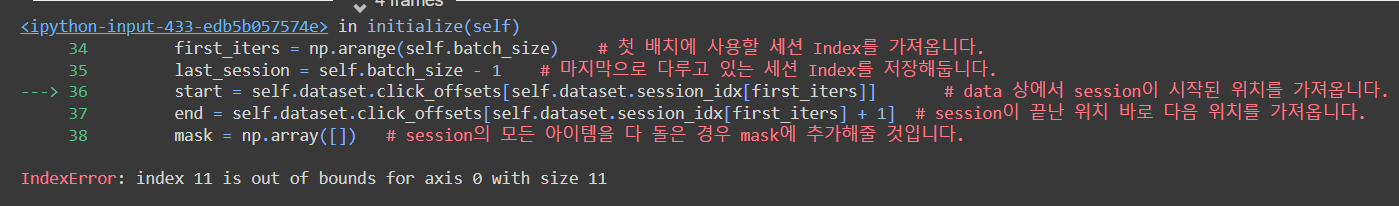

2. end[idx] = self.dataset.click_offsets[min(self.dataset.session_idx[new_session] + 1, len(self.dataset.click_offsets) - 1)] 코드를 수정하여 indexError를 넘어갔다.

In [426]:
tr_dataset

In [427]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Unix_Time,Time,SessionId,item_idx
8798,59,2396,4,1041962835,2003-01-07 18:07:15,130,0
8733,59,2300,4,1041966942,2003-01-07 19:15:42,130,1
8879,59,1220,4,1041967022,2003-01-07 19:17:02,130,2
8728,59,750,4,1041967123,2003-01-07 19:18:43,130,3
8876,59,541,4,1041967123,2003-01-07 19:18:43,130,4
8891,59,3911,4,1041967346,2003-01-07 19:22:26,130,5
8899,59,1234,4,1041967995,2003-01-07 19:33:15,131,6
8882,59,2028,4,1041968094,2003-01-07 19:34:54,131,7
58836,398,2028,4,1044565425,2003-02-06 21:03:45,1519,7
58828,398,2959,5,1044565595,2003-02-06 21:06:35,1519,8


In [428]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.

input, output, mask의 감을 잡아 봅시다.

In [429]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  6  7 18]
Label Item Idx are :       [1 7 8 6]
Previous Masked Input Idx are []


# 4-5. Modeling
## 5.1 Evaluation Metric
모델 성능 평가를 위한 지표를 보겠습니다.
모델 성능에 대한 지표로 precision이나 recall이 있습니다.

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.

이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.

추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.

따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.

이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.

따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.

In [430]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 5.2 Model Architecture
스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [431]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [432]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [433]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=1, hsz=50, drop_rate=0.2, lr=0.00001, epochs=5, k=20)

In [434]:
model = create_model(args)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(1, 1, 22)]              0         
                                                                 
 GRU (GRU)                   [(1, 50),                 11100     
                              (1, 50)]                           
                                                                 
 dropout_22 (Dropout)        (1, 50)                   0         
                                                                 
 dense_16 (Dense)            (1, 22)                   1122      
                                                                 
Total params: 12222 (47.74 KB)
Trainable params: 12222 (47.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training

In [435]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [436]:
train_model(model, args)

# # 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00,  9.70it/s]


	 - Recall@20 epoch 1: 0.666667
	 - MRR@20    epoch 1: 0.149074



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 14.73it/s]


	 - Recall@20 epoch 2: 0.666667
	 - MRR@20    epoch 2: 0.149074



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 14.73it/s]


	 - Recall@20 epoch 3: 0.666667
	 - MRR@20    epoch 3: 0.149074



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 13.98it/s]


	 - Recall@20 epoch 4: 0.666667
	 - MRR@20    epoch 4: 0.130556



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 14.52it/s]

	 - Recall@20 epoch 5: 0.666667
	 - MRR@20    epoch 5: 0.130556



## ㄴ Ruburic 2.
: RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.

# 5.4 Inference
지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증해 봅시다.

In [437]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 6/6 [00:00<00:00, 15.07it/s]

	 - Recall@20: 1.000000
	 - MRR@20: 0.266667



### ㄴ 결과
: Recall@20: 1.000000, MRR@20: 0.266667

## Ruburic 3.
: 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.

In [438]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

### ㄴ 1. 모델구조 변경
: GRU layer를 추가

In [439]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=1, hsz=50, drop_rate=0.2, lr=0.00001, epochs=5, k=20)

### ㄴ 2. 하이퍼파라미터 최적화(기준 Metric - recall@20)
- batch size - 주어진 colab 환경에서 batch size 가 1일 때 학습과정이 정상적이게 진행되었다. 1이 아니면 IndexError 가 발생하였다.
- hsz - GRU layer의 demension은 10, 20 , 30, 50, 70, 90인 경우를 실험했을 때, 50이 가장 준수한 예측성능을 나타냈다.
- dropout rate - 0.1, 0.2, 0.3, 0.5, 0.7, 0.9인 경우를 실험했을 때 0.2일 때 가장 높은 예측성능을 나타냈다.
- learning rate - lr은 학습에 큰 영향을 끼치지 못했다. 주어진 데이터의 크기가 작기 때문에 학습과정에서 overfitting이 발생하였다.
- epoch - overfitting 발생으로 epoch을 5 이내로 적용하였다. 학습을 많이 하면 validation 지표가 좋지 않게 나왔다.

In [440]:
model_improved = create_model(args)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(1, 1, 22)]              0         
                                                                 
 GRU (GRU)                   [(1, 50),                 11100     
                              (1, 50)]                           
                                                                 
 dropout_24 (Dropout)        (1, 50)                   0         
                                                                 
 dense_17 (Dense)            (1, 22)                   1122      
                                                                 
Total params: 12222 (47.74 KB)
Trainable params: 12222 (47.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training


In [441]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [442]:
train_model(model_improved, args)

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  78%|███████▊  | 7/9 [00:01<00:00,  6.89it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s]


	 - Recall@20 epoch 1: 0.777778
	 - MRR@20    epoch 1: 0.179459



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 14.60it/s]


	 - Recall@20 epoch 2: 0.777778
	 - MRR@20    epoch 2: 0.179459



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 14.81it/s]


	 - Recall@20 epoch 3: 0.777778
	 - MRR@20    epoch 3: 0.181311



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 14.75it/s]


	 - Recall@20 epoch 4: 0.777778
	 - MRR@20    epoch 4: 0.181311



Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 9/9 [00:00<00:00, 13.82it/s]

	 - Recall@20 epoch 5: 0.777778
	 - MRR@20    epoch 5: 0.181311



# Inference

In [443]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 6/6 [00:00<00:00, 14.03it/s]

	 - Recall@20: 1.000000
	 - MRR@20: 0.127976



### 3. 데이터 설계 및 세션정의
- 데이터 설계 : rating이 3이상인 데이터를 포함했을 때보다 4이상인 데이터를 기준으로 모델링 했을 때 더 좋은 성능이 나타났다. 또한 train set 26일, validation set 2일, test set 2일인 경우보다 train set 50일, validation set 5일, test set 5일로 모델링했을 때 더 높은 recall@20, MRR@20 결과를 확인하였다.
- 세션정의 : 세션 정의를 30, 60, 90분 단위로 실험을 하였다. 최적화한 파라미터와 데이터 설계를 기준으로 세션을 90분 단위로 모델링을 했을 때 가장 높은 recall, mrr 결과를 얻게 되었다.


## 결과
1. 모델 변경 단계에서 GRU layer를 2개로 증가시켰을 때와 1개일 때를 비교하면 recall@20 값은 모두 1.00이 나왔다.
2. GRU layer가 2개인 경우 학습 단계에서 validation recall@20 값과 MRR@20 값이 더 높게 나왔다.
3. 그러나 예측성능에서 MRR@20 지표는 GRU layer가 1개였을 때 더 높게 나타났다(0.266667 <-> 0.127976).
4. 데이터의 크기가 작기 때문에 layer를 추가하는 경우 오버피팅이 발생한 것으로 생각된다.
#### GRU layer 1개 : recall@20 - 1.00,  MRR@20 - 0.27
#### GRU layer 2개 : recall@20 - 1.00,  MRR@20 - 0.13

## 회고
- 문제해결
1. Movielens 데이터는 UserId 기반의 데이터이다. 따라서 Session-based Recommendation 모델을 적용하기 위해 데이터를 세션단위로 재정의하고, rating 데이터를 4점 이상인 데이터만 필터링하여 CTR 지표 대용으로 활용하였다.
2. 데이터를 세션단위로 전처리할 때 Unix Time 90분을 기준으로 bucketing 하였다. UserId에 따른 구분 또한 코드를 통해 구현하였고, 그 결과를 직접 출력하여 세션화가 성공적으로 진행되었는지 확인하였다.
3. Train 단계에서 발생한 IndexError 문제를 batch size와 관련된 코드를 확인하면서 해결하였다.
4. 하이퍼파라미터 최적화 실험, 훈련/검증/예측 데이터 50/5/5일치 활용, 세션단위 90분/ GRU layer 개수에 따른 성능 평가 실험을 통하여 'Recall@20 : 1.00  /  MRR@20 : 0.27 '와 같은 최종 예측성능을 산출하였다.

- 배운 점
1. Debugging 과정에서 모델 학습을 위해 데이터를 로드하고 배치단위로 input 형태를 정의하는 코드를 익힐 수 있었다.
2. SBR 모델에 맞게 문제를 정의하고 데이터를 재구성하여 프로젝트를 완수하였다.
3. Unix Time이 UTC Time으로 잘못 표기된 것 같아 이를 정정하였다.